In [2]:
import numpy as np
import matplotlib.pyplot as plt

import importlib
import os, sys
sys.path.append(os.path.abspath(".."))

In [3]:
# --------------------------
# Module reload utility cell
# --------------------------
import importlib
import models.bs
import models.heston
import models.doubleheston
import plotting.plot_utils
import utils.hedging

# Reload modules to pick up edits
importlib.reload(models.bs)
importlib.reload(models.heston)
importlib.reload(models.doubleheston)
importlib.reload(plotting.plot_utils)
importlib.reload(utils.hedging)

<module 'utils.hedging' from '/home/machine/Desktop/ErdosFinance2025/utils/hedging.py'>

# The Double Heston Model

In the Double Heston model, the asset is assumed to follow the dynamics given by these equations
$$\begin{align} \frac{d S_t}{S_t} & = r dt + \sqrt{v_1} d W_t^1 + \sqrt{v_2} dW_t^2 \\
d V_t^1 & = \kappa_1 (\theta_1 - v_1) dt + \sigma_1 \sqrt{v1} d Z_t^1 \\
dV_t^2 & = \kappa_2 (\theta_2-v_t^2) dt + \sigma_2 \sqrt{v_t^2} d Z_t^2\end{align} $$ with the following stochastic structure 
$$ \begin{align} \langle dW^1, dZ^1 \rangle_t & = \rho_1 dt \\
\langle dW^2, dZ^2 \rangle_t &= \rho_2 dt \\
\langle dW^1, dW^2 \rangle_t &= 0 \\
\langle dZ^1, dZ^2 \rangle_t &= 0
\end{align} $$

The discretization of these equations is not trivial, and my implementation follows the scheme introduced in Efficient Simulation of the Double Heston model by Gauthier and Possamai, 2010.

One of the big advantages of the Double Heston model is that it remains analytically tractable. For my implementation I followed the derivation of the characteristic functions presented in The Heston Model and its Extensions in Matlab and C# by Rouah, 2013. The implementation uses the Heston trap for stability.


## 1. Monte Carlo Price Convergence

Let us first see that the calculated price using Monte Carlo for the discretization from Gauthier and Possamai behaves as theory predicts (error decay like $1/\sqrt{N}$), where $N$ is the number of paths. I first calculate the exact price using the implementation of the analytical formula in the DoubleHeston class and plot the absolute errors for the average of increasing number of paths. Additionally, I calculate a high precision estimate of the Monte Carlo price using the average of 6 runs of the MC price with one million paths and plot the absolute errors for this reference value. 

I assume that the Double Heston model has parameters $$\begin{align} r & =  6 & q & =0 \\ \kappa_1 & = 0.9 & \kappa_2 &=1.2 \\ \theta_1 &= 0.1 & \theta_2 &=0.15 \\ \sigma_1 & = 0.1 & \sigma_2 &= 0.2 \\ \rho_1 &= -0.5 & \rho_2 &= -0.5,\end{align}$$ and consider an option with strike $K=61.9$, maturity $T=1.0$, initial price $S=61.9$, initial volatiliy $v_1=0.6^2$, and initial volatility $v_2=0.7^2$. These parameters will be the same in the rest of the experiments

CF price:  19.453781506697773

Computing MC price reference using a large number of paths...
Computed MC price reference. Repetition: 1/5.
Computed MC price reference. Repetition: 2/5.
Computed MC price reference. Repetition: 3/5.
Computed MC price reference. Repetition: 4/5.
Computed MC price reference. Repetition: 5/5.
MC price reference using a large number of paths (discretization-biased): 19.585406896656384
Running MC convergence test for smaller N_paths...
MC paths=   100 → mean=19.286467, std=4.030025 | diff from CF=-0.167315 | diff from ref MC=-0.298940
MC paths=   400 → mean=19.722274, std=2.257528 | diff from CF=0.268493 | diff from ref MC=0.136867
MC paths=  1600 → mean=19.746318, std=1.192834 | diff from CF=0.292537 | diff from ref MC=0.160911
MC paths=  6400 → mean=19.519646, std=0.547967 | diff from CF=0.065865 | diff from ref MC=-0.065761
MC paths= 25600 → mean=19.552793, std=0.276173 | diff from CF=0.099011 | diff from ref MC=-0.032614
MC paths=102400 → mean=19.601418, 

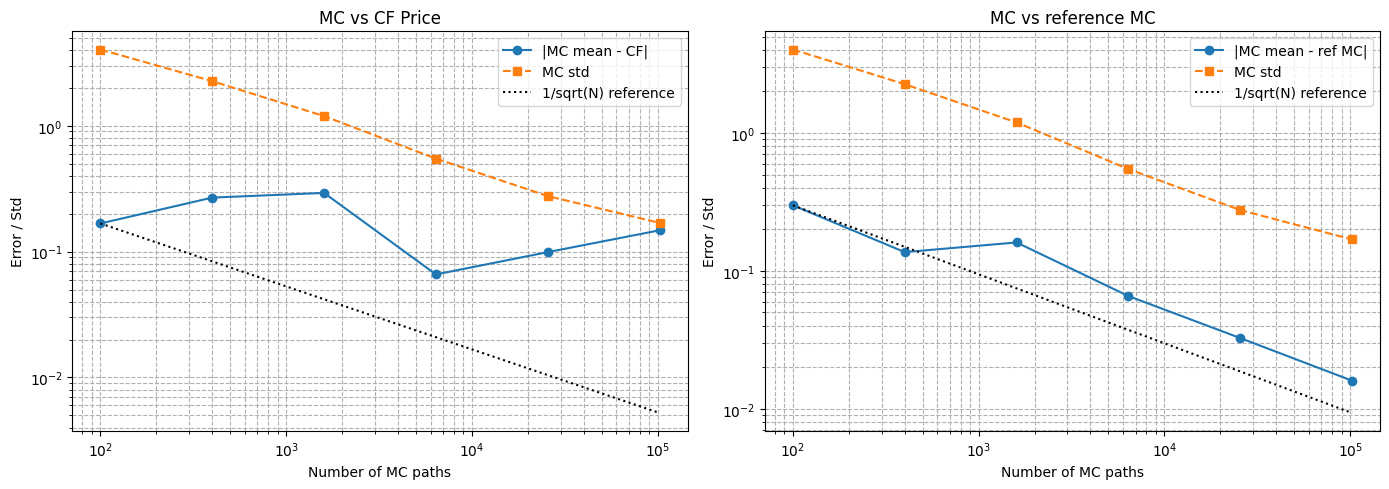

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import models.doubleheston  

# ----------------------
# Model & parameters
# ----------------------
DoubleHeston_ref = models.doubleheston.DoubleHeston(
    r=0.03, q=0.0, kappa1=0.9, kappa2=1.2,
    theta1=0.1, theta2=0.15, sigma1=0.1, sigma2=0.2,
    rho1=-0.5, rho2=-0.5
)

K, T, S0, v01, v02 = 61.9, 1.0, 61.9, 0.6**2, 0.7**2

# MC parameters
N_steps = 252
mc_sizes = [4**i*100 for i in range(6)]
n_repeats = 50
N_paths_large = int(1e6)
n_repeats_large = 5

# ----------------------
# Folder setup
# ----------------------
results_folder = "../results"
os.makedirs(results_folder, exist_ok=True)
filename = os.path.join(results_folder, "mc_convergence_results.npz")

# ----------------------
# Compute CF price (always cheap)
# ----------------------
S = np.array([[S0]])
V1 = np.array([[v01]])
V2 = np.array([[v02]])
Tau = np.array([[T]])

greeks_cf = DoubleHeston_ref.price_greeks_vect(
    K=K, Tau=Tau, S=S, V1=V1, V2=V2,
    quad_rule='laguerre', quad_params={'nodes':64}
)
cf_price = greeks_cf["Price_call"][0,0]
print("CF price: ", cf_price)
print()

# ----------------------
# Check if cached results exist and match parameters
# ----------------------
recompute = True
if os.path.exists(filename):
    print(f"Found cached results '{filename}' — checking parameters...")
    data = np.load(filename, allow_pickle=True)
    cached_params = data['params'].item()  # stored as dict
    if (cached_params.get('N_steps') == N_steps and
        cached_params.get('n_repeats') == n_repeats and
        cached_params.get('N_paths_large') == N_paths_large and
        cached_params.get('n_repeats_large') == n_repeats_large):
        print("Cached results match parameters. Loading...")
        npaths_arr = data['npaths_arr']
        mean_mc_arr = data['mean_mc_arr']
        std_mc_arr  = data['std_mc_arr']
        mc_ref      = data['mc_ref'].item()
        recompute = False
    else:
        print("Cached results do not match parameters. Recomputing MC...")

if recompute:
    # ----------------------
    # Large N_paths reference
    # ----------------------
    print("Computing MC price reference using a large number of paths...")
    mc_large_estimates = []
    for rep in range(n_repeats_large):
        mc_price = DoubleHeston_ref.mc_price(
            K=K, T=T, S0=S0, v01=v01, v02=v02,
            N_paths=N_paths_large, N_steps=N_steps, seed=rep
        )
        mc_large_estimates.append(mc_price)
        print(f"Computed MC price reference. Repetition: {rep+1}/{n_repeats_large}.")
    mc_ref = np.mean(mc_large_estimates)
    print("MC price reference using a large number of paths (discretization-biased):", mc_ref)

    # ----------------------
    # MC convergence test
    # ----------------------
    print("Running MC convergence test for smaller N_paths...")
    mc_results = []
    for npaths in mc_sizes:
        mc_estimates = []
        for rep in range(n_repeats):
            mc_price = DoubleHeston_ref.mc_price(
                K=K, T=T, S0=S0, v01=v01, v02=v02,
                N_paths=npaths, N_steps=N_steps, seed=rep
            )
            mc_estimates.append(mc_price)
        mc_estimates = np.array(mc_estimates)
        mean_mc = mc_estimates.mean()
        std_mc  = mc_estimates.std(ddof=1)
        mc_results.append((npaths, mean_mc, std_mc))
        print(f"MC paths={npaths:6d} → mean={mean_mc:.6f}, std={std_mc:.6f} | diff from CF={mean_mc - cf_price:.6f} | diff from ref MC={mean_mc - mc_ref:.6f}")

    mc_results = np.array(mc_results)
    npaths_arr = mc_results[:,0]
    mean_mc_arr = mc_results[:,1]
    std_mc_arr = mc_results[:,2]

    # Save results + parameters
    params = {
        'N_steps': N_steps,
        'n_repeats': n_repeats,
        'N_paths_large': N_paths_large,
        'n_repeats_large': n_repeats_large
    }
    np.savez_compressed(
        filename,
        npaths_arr=npaths_arr,
        mean_mc_arr=mean_mc_arr,
        std_mc_arr=std_mc_arr,
        cf_price=cf_price,
        mc_ref=mc_ref,
        params=params
    )
    print(f"MC convergence results saved to '{filename}'")

# ----------------------
# Plot side by side
# ----------------------
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# 1) MC vs CF
error_cf = np.abs(mean_mc_arr - cf_price)
axes[0].loglog(npaths_arr, error_cf, 'o-', label='|MC mean - CF|')
axes[0].loglog(npaths_arr, std_mc_arr, 's--', label='MC std')
axes[0].loglog(npaths_arr, 1/np.sqrt(npaths_arr)*error_cf[0]*np.sqrt(npaths_arr[0]), 'k:', label='1/sqrt(N) reference')
axes[0].set_xlabel('Number of MC paths')
axes[0].set_ylabel('Error / Std')
axes[0].set_title('MC vs CF Price')
axes[0].legend()
axes[0].grid(True, which='both', ls='--')

# 2) MC vs Large-path MC reference
error_ref = np.abs(mean_mc_arr - mc_ref)
axes[1].loglog(npaths_arr, error_ref, 'o-', label='|MC mean - ref MC|')
axes[1].loglog(npaths_arr, std_mc_arr, 's--', label='MC std')
axes[1].loglog(npaths_arr, 1/np.sqrt(npaths_arr)*error_ref[0]*np.sqrt(npaths_arr[0]), 'k:', label='1/sqrt(N) reference')
axes[1].set_xlabel('Number of MC paths')
axes[1].set_ylabel('Error / Std')
axes[1].set_title('MC vs reference MC')
axes[1].legend()
axes[1].grid(True, which='both', ls='--')

plt.tight_layout()
fig.savefig(os.path.join(results_folder, "mc_convergence_plot.png"))
plt.show()


As we can see, the error an variance do follow the predicted $1/\sqrt{N}$ once the bias of the Euler discretization is accounted for.

## 2. Hedging under risk-free and general drifts

This experiment shows the results of hedging under the risk-neutral and general drifts. We take $\mu=r=0.03$ as the risk-free drift and $\mu=0.23$ for comparison. The Double Heston model is assumed to have parameters 
$$\begin{align} r & =  6 & q & =0 \\ \kappa_1 & = 0.9 & \kappa_2 &=1.2 \\ \theta_1 &= 0.1 & \theta_2 &=0.15 \\ \sigma_1 & = 0.1 & \sigma_2 &= 0.2 \\ \rho_1 &= -0.5 & \rho_2 &= -0.5,\end{align}$$ and we consider a call option with strike $K=61.9$, maturity $T=1.0$, initial price $S=61.9$, initial volatiliy $v_1=0.6^2$, and initial volatility $v_2=0.7^2$.


Found cached results '../results/hedging_dh_results.npz' — checking parameters...
Cached results match parameters. Loading...


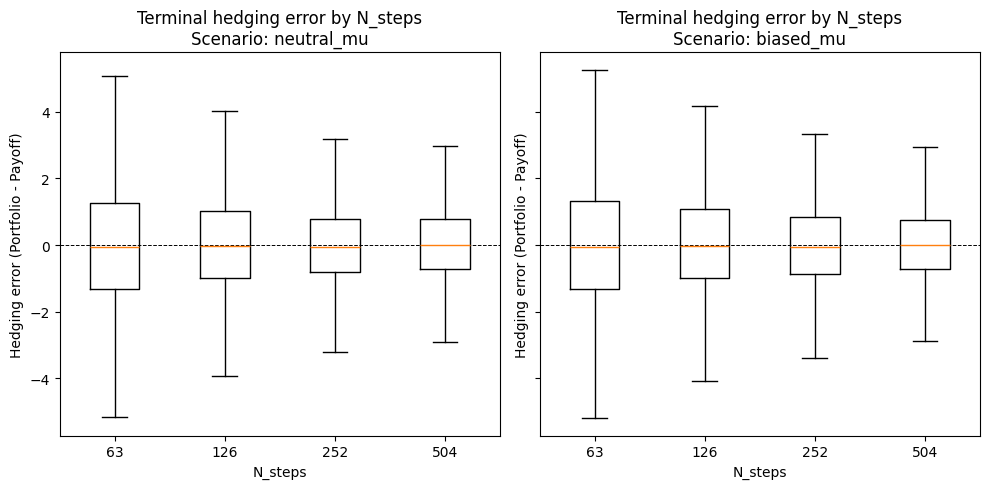

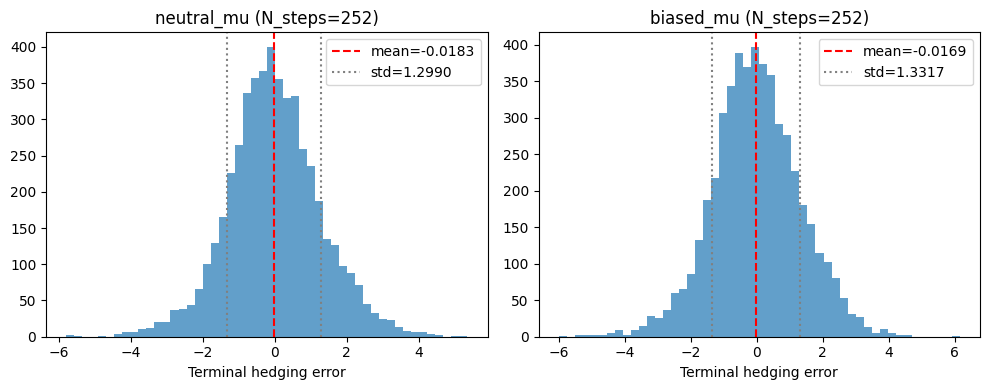

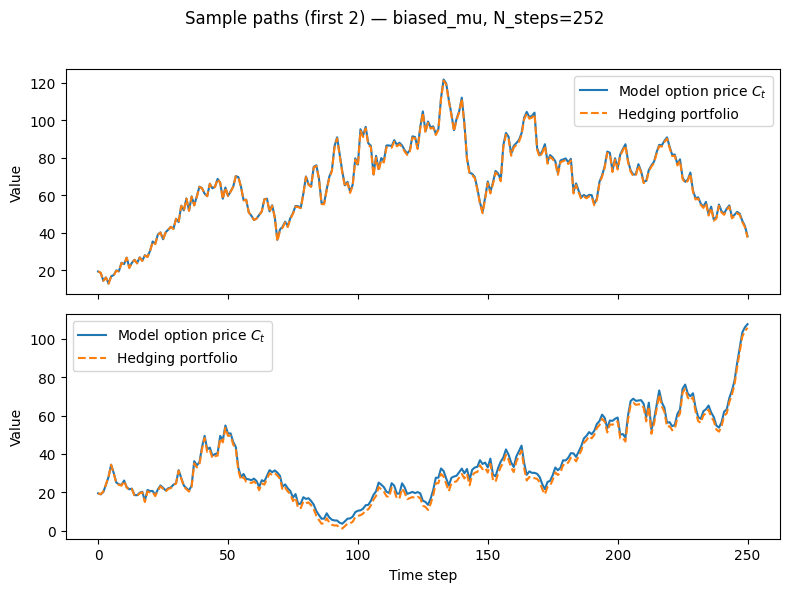


Summary table (mean, std of terminal hedging error):

Scenario: neutral_mu
  N_steps= 63  mean=-0.037536  std= 2.152264
  N_steps=126  mean= 0.003969  std= 1.612985
  N_steps=252  mean=-0.018308  std= 1.298979
  N_steps=504  mean= 0.033126  std= 1.107140

Scenario: biased_mu
  N_steps= 63  mean=-0.050878  std= 2.156477
  N_steps=126  mean= 0.006237  std= 1.632398
  N_steps=252  mean=-0.016860  std= 1.331665
  N_steps=504  mean= 0.025091  std= 1.127839


In [62]:
import os
import numpy as np
import matplotlib.pyplot as plt
import models.doubleheston
import utils.hedging

# ----------------------
# Model & parameters
# ----------------------
DoubleHeston_ref = models.doubleheston.DoubleHeston(
    r=0.03, q=0.0,
    kappa1=0.9, kappa2=1.2,
    theta1=0.1, theta2=0.15,
    sigma1=0.1, sigma2=0.2,
    rho1=-0.5, rho2=-0.5
)

K, T, S0, v01, v02 = 61.9, 1.0, 61.9, 0.6**2, 0.7**2

# Hedging experiment parameters
N_paths = 5000
nsteps_list = [63*2**i for i in range(4)]
seed = 20

# Quadrature
quad_rule = 'laguerre'
quad_params = {'nodes': 32}

# Drift scenarios
scenarios = {
    "neutral_mu": DoubleHeston_ref.r,
    "biased_mu": DoubleHeston_ref.r + 0.2
}

# ----------------------
# Folder setup
# ----------------------
results_folder = "../results"
os.makedirs(results_folder, exist_ok=True)
filename = os.path.join(results_folder, "hedging_dh_results.npz")

# ----------------------
# Check if cached results exist
# ----------------------
recompute = True
if os.path.exists(filename):
    print(f"Found cached results '{filename}' — checking parameters...")
    data = np.load(filename, allow_pickle=True)
    cached_params = data['params'].item()
    if (cached_params.get('N_paths') == N_paths and
        cached_params.get('nsteps_list') == nsteps_list and
        cached_params.get('seed') == seed):
        print("Cached results match parameters. Loading...")
        results = data['results'].item()
        recompute = False
    else:
        print("Cached results do not match parameters. Recomputing...")

if recompute:
    results = {}
    for scen_name, mu in scenarios.items():
        results[scen_name] = {}
        print(f"\n--- Scenario: {scen_name} (mu = {mu:.4f}) ---")
        for N_steps in nsteps_list:
            print(f"Running delta hedge: N_paths={N_paths}, N_steps={N_steps} ...", end="", flush=True)
            out = utils.hedging.delta_hedge(
                model=DoubleHeston_ref, mu=mu, K=K, T=T, S0=S0,
                v01=v01, v02=v02,
                N_paths=N_paths, N_steps=N_steps, seed=seed,
                quad_rule=quad_rule, quad_params=quad_params
            )
            hed_err = out['hedging_error_T']
            mean_err = np.mean(hed_err)
            std_err = np.std(hed_err)
            results[scen_name][N_steps] = {
                'out': out,
                'mean': mean_err,
                'std': std_err,
                'hed_err': hed_err
            }
            print(f" done. mean={mean_err:.6f}, std={std_err:.6f}")

    # Save results + parameters
    params = {
        'N_paths': N_paths,
        'nsteps_list': nsteps_list,
        'seed': seed
    }
    np.savez_compressed(filename, results=results, params=params)
    print(f"\nHedging results saved to '{filename}'")

# ----------------------
# Plots and summaries
# ----------------------

# 1) Boxplot of terminal hedging error vs rebalancing frequency
fig, axes = plt.subplots(1, len(scenarios), figsize=(5*len(scenarios), 5), sharey=True)
if len(scenarios) == 1:
    axes = [axes]
for ax, (scen_name, dic) in zip(axes, results.items()):
    data = [dic[n]['hed_err'] for n in nsteps_list]
    ax.boxplot(data, tick_labels=[str(n) for n in nsteps_list], showfliers=False)
    ax.axhline(0, color='k', linestyle='--', linewidth=0.7)
    ax.set_title(f"Terminal hedging error by N_steps\nScenario: {scen_name}")
    ax.set_xlabel("N_steps")
    ax.set_ylabel("Hedging error (Portfolio - Payoff)")
plt.tight_layout()
fig.savefig(os.path.join(results_folder, "hedging_dh_boxplot.png"))
plt.show()

# 2) Histogram of terminal hedging error for middle N_steps
chosen_n = nsteps_list[-2]
fig, axes = plt.subplots(1, len(scenarios), figsize=(5*len(scenarios), 4))
if len(scenarios) == 1:
    axes = [axes]
for ax, (scen_name, dic) in zip(axes, results.items()):
    hed = dic[chosen_n]['hed_err']
    ax.hist(hed, bins=50, density=False, alpha=0.7)
    ax.axvline(np.mean(hed), color='red', linestyle='--', label=f"mean={np.mean(hed):.4f}")
    ax.axvline(np.mean(hed)+np.std(hed), color='gray', linestyle=':', label=f"std={np.std(hed):.4f}")
    ax.axvline(np.mean(hed)-np.std(hed), color='gray', linestyle=':')
    ax.set_title(f"{scen_name} (N_steps={chosen_n})")
    ax.set_xlabel("Terminal hedging error")
    ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(results_folder, f"hedging_dh_hist_N{chosen_n}.png"))
plt.show()

# 3) Sample path plots: option price vs hedging portfolio
example_scenario = 'biased_mu'
example_N = nsteps_list[-2]
ex = results[example_scenario][example_N]['out']
S = ex['S']
Price_call = ex['Price_call']
Portfolio = ex['Portfolio']

chosen_paths = [ 162, 55] 
n_show = len(chosen_paths)#min(3, N_paths)
fig, axes = plt.subplots(n_show, 1, figsize=(8, 3*n_show), sharex=True)
threshold = 1e-4  # defines what price of call is "effectively zero" for plotting purposes
for i, path_idx in enumerate(chosen_paths): 
    price_line = Price_call[path_idx,:].copy()
    zero_start = np.argmax(price_line < threshold) if np.any(price_line < threshold) else len(price_line)
    price_line[zero_start:] = 0.0
    axes[i].plot(price_line[:-1], label='Model option price $C_t$')
    #axes[i].plot(Price_call[path_idx,:], label='Model option price $C_t$')
    axes[i].plot(Portfolio[path_idx,:-1], '--', label='Hedging portfolio')
    axes[i].set_ylabel("Value")
    axes[i].legend()
axes[-1].set_xlabel("Time step")
plt.suptitle(f"Sample paths (first {n_show}) — {example_scenario}, N_steps={example_N}")
plt.tight_layout(rect=[0,0,1,0.96])
fig.savefig(os.path.join(results_folder, f"hedging_dh_paths_{example_scenario}_N{example_N}.png"))
plt.show()

# 4) Summary table
print("\nSummary table (mean, std of terminal hedging error):")
for scen_name, dic in results.items():
    print(f"\nScenario: {scen_name}")
    for N_steps in nsteps_list:
        mean_err = dic[N_steps]['mean']
        std_err = dic[N_steps]['std']
        print(f"  N_steps={N_steps:3d}  mean={mean_err: .6f}  std={std_err: .6f}")

From the plots we can see that in both the risk-free and general drift the hedging errors have means close to zero and that the dispersion of these errors decrease as the rebalancing of the portfolio increases. Even in the general drift case, the portfolio is able to replicate the price of the option very closely, as shown in the plot containing a selection of hedging paths.

The following experiment shows that for a set of different values of $\mu$, the mean of the error is around zero using a t-test. I attribute the cases where $p<0.5$ for moderate values of $\mu$ to inherent random of the Monte Carlo process. Running the simulations several times and averaging could make results more conclusive:

In [60]:
import numpy as np
from scipy import stats
import utils.hedging as hedging
from models.doubleheston import DoubleHeston

m = DoubleHeston(r=0.03, q=0.0, kappa1=0.9, kappa2=1.2, theta1=0.1, theta2=0.15,
                 sigma1=0.1, sigma2=0.2, rho1=-0.5, rho2=-0.5)

K=61.9; T=1.0; S0=61.9; v01=0.6**2; v02=0.7**2
quad_rule='laguerre'; quad_params={'nodes':32}
N_paths = 5000   # increase if you want more power
mus = [0.03, 0.23, 0.5, 1.0]
nsteps_list = [63*2**i for i in range(0,4)]

results_table = {}
for mu in mus:
    results_table[mu] = {}
    for N_steps in nsteps_list:
        out = hedging.delta_hedge(model=m, mu=mu, K=K, T=T, S0=S0,
                                  v01=v01, v02=v02, N_paths=N_paths, N_steps=N_steps, seed=20,
                                  quad_rule=quad_rule, quad_params=quad_params)
        hed = out['hedging_error_T']
        mean = float(np.mean(hed)); std = float(np.std(hed))
        tstat, pval = stats.ttest_1samp(hed, 0.0)
        results_table[mu][N_steps] = {'mean':mean, 'std':std, 'tstat':float(tstat), 'pval':float(pval)}
        print(f"mu={mu:.2f}, N_steps={N_steps} -> mean={mean:.6e}, std={std:.6e}, pval={pval:.4f}")


-0.03753639314028718 2.1522641863271534
mu=0.03, N_steps=63 -> mean=-3.753639e-02, std=2.152264e+00, pval=0.2176
0.0039691051102046715 1.6129853206692792
mu=0.03, N_steps=126 -> mean=3.969105e-03, std=1.612985e+00, pval=0.8619
-0.01830843608224597 1.2989789285148625
mu=0.03, N_steps=252 -> mean=-1.830844e-02, std=1.298979e+00, pval=0.3190
0.033125829177165965 1.1071397246153165
mu=0.03, N_steps=504 -> mean=3.312583e-02, std=1.107140e+00, pval=0.0344
-0.05087792347729005 2.1564773093333915
mu=0.23, N_steps=63 -> mean=-5.087792e-02, std=2.156477e+00, pval=0.0954
0.0062370021062754175 1.6323975342944597
mu=0.23, N_steps=126 -> mean=6.237002e-03, std=1.632398e+00, pval=0.7871
-0.016859662582157965 1.3316650873758733
mu=0.23, N_steps=252 -> mean=-1.685966e-02, std=1.331665e+00, pval=0.3708
0.025090858000161188 1.1278393758106888
mu=0.23, N_steps=504 -> mean=2.509086e-02, std=1.127839e+00, pval=0.1158
-0.09004954426894823 2.1292354950304286
mu=0.50, N_steps=63 -> mean=-9.004954e-02, std=2.12

In this plot we see how the mean hedging error approaches zero as the number of rebalancing steps increases, for different values of $\mu$. From numbers alone it was hard to see, but from this plot we can see that the mean hedding error starts closer to zero and approaches zero faster the closer $\mu$ is to the risk-neutral drift. 

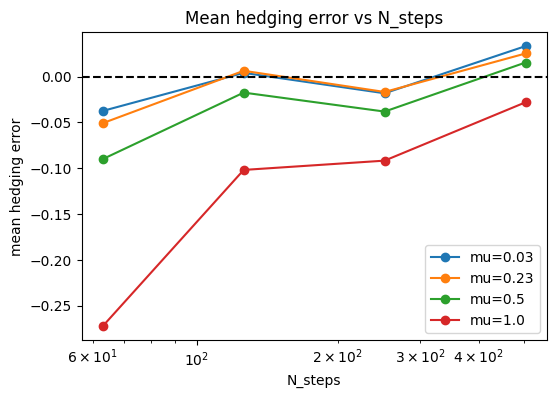

In [61]:
import matplotlib.pyplot as plt

mus = [0.03, 0.23, 0.5, 1.0]
nsteps_list = [63*2**i for i in range(0,4)]
plt.figure(figsize=(6,4))
for mu in mus:
    means = [results_table[mu][n]['mean'] for n in nsteps_list]
    plt.plot(nsteps_list, means, marker='o', label=f"mu={mu}")
plt.axhline(0, color='k', linestyle='--')
plt.xscale('log'); plt.xlabel('N_steps'); plt.ylabel('mean hedging error')
plt.title('Mean hedging error vs N_steps'); plt.legend()
plt.show()

To make sure that a mean hedging error that is consistently close to zero for different values of $\mu$ is not just a result of my implementation of the hedging routine or dynamics, we can try to hedge under values of $\mu$ that are unrealistically large. As we can see, the standard deviations of the hedging errors are huge and sometimes the mean itself is very large.

In [62]:
extreme_mus = [2.0, 3.0, 5.0]  # unrealistic
for mu in extreme_mus:
    out = hedging.delta_hedge(model=m, mu=mu, K=K, T=T, S0=S0,
                              v01=v01, v02=v02, N_paths=5000, N_steps=200, seed=1,
                              quad_rule=quad_rule, quad_params=quad_params)
    hed = out['hedging_error_T']
    print("mu=", mu, "mean=", np.mean(hed), "std=", np.std(hed))

-0.09983361885181753 6.180561172766696
mu= 2.0 mean= -0.09983361885181753 std= 6.180561172766696
-0.21227082850007137 30.940374752433424
mu= 3.0 mean= -0.21227082850007137 std= 30.940374752433424
30.660752997914916 523.0288089034738
mu= 5.0 mean= 30.660752997914916 std= 523.0288089034738


## Hedging using a mismatched model

The deals with hedging when the assumed model doesn't match the asset dynamics. We that the asset follows the dynamics of a Double Heston model with parameters 
$$\begin{align} r & =  6 & q & =0 \\ \kappa_1 & = 0.9 & \kappa_2 &=1.2 \\ \theta_1 &= 0.1 & \theta_2 &=0.15 \\ \sigma_1 & = 0.1 & \sigma_2 &= 0.2 \\ \rho_1 &= -0.5 & \rho_2 &= -0.5,\end{align}$$ and we consider a call option with strike $K=61.9$, maturity $T=1.0$, initial price $S=61.9$, initial volatiliy $v_1=0.6^2$, and initial volatility $v_2=0.7^2$.

For hedging I will use the following models:
1. Double Heston model
2. Heston model with volatility equal to $v_1$
3. Heston model with volatility equatl to $v_1+v_2$

Found cached results '../results/hedging_dh_mismatch_results.npz' — checking parameters...
Cached results match parameters. Loading...


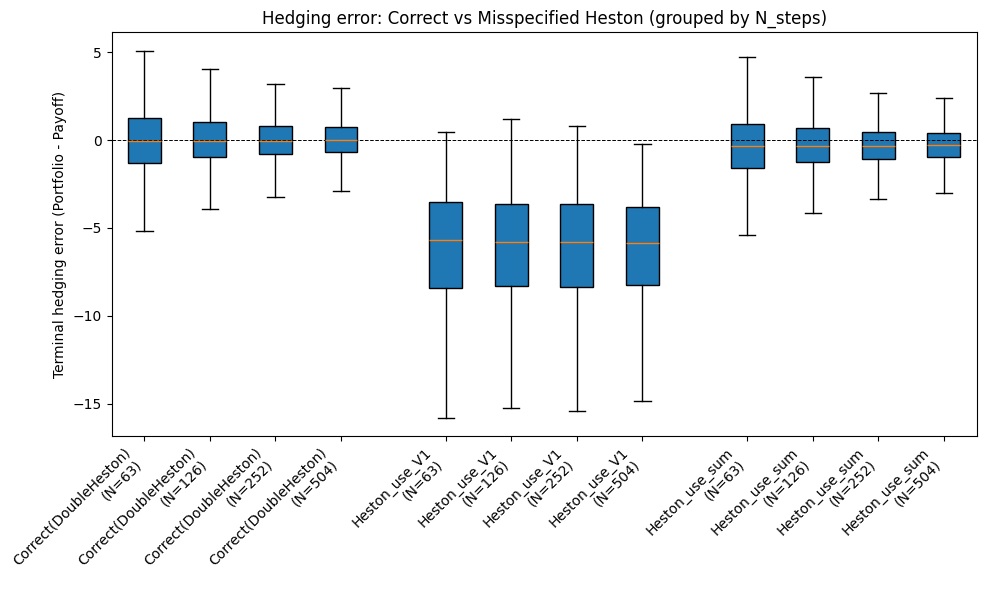

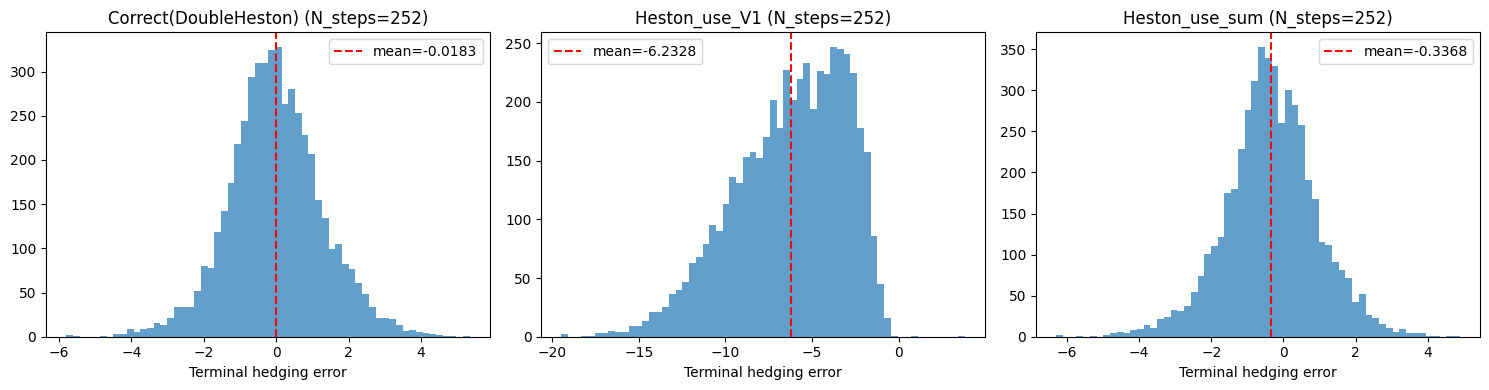


Summary (mean, std) of terminal hedging error:

Method: Correct(DoubleHeston)
  N_steps= 63  mean=-0.037536  std= 2.152264
  N_steps=126  mean= 0.003969  std= 1.612985
  N_steps=252  mean=-0.018308  std= 1.298979
  N_steps=504  mean= 0.033126  std= 1.107140

Method: Heston_use_V1
  N_steps= 63  mean=-6.321673  std= 3.639564
  N_steps=126  mean=-6.262481  std= 3.339061
  N_steps=252  mean=-6.232794  std= 3.206218
  N_steps=504  mean=-6.217142  std= 3.104358

Method: Heston_use_sum
  N_steps= 63  mean=-0.359065  std= 2.145629
  N_steps=126  mean=-0.316730  std= 1.601740
  N_steps=252  mean=-0.336807  std= 1.278222
  N_steps=504  mean=-0.288107  std= 1.082295


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from models.doubleheston import DoubleHeston
from models.heston import Heston
import utils.hedging as hedging

# ----------------------
# Base (true) Double Heston model parameters
# ----------------------
true = DoubleHeston(r=0.03, q=0.0,
                    kappa1=0.9, kappa2=1.2,
                    theta1=0.1, theta2=0.15,
                    sigma1=0.1, sigma2=0.2,
                    rho1=-0.5, rho2=-0.5)

K, T, S0, v01, v02 = 61.9, 1.0, 61.9, 0.6**2, 0.7**2

# Quad rule
quad_rule = 'laguerre'
quad_params = {'nodes': 32}

# Simulation / hedging settings
N_paths = 5000
nsteps_list = [63*2**i for i in range(4)]#[50, 100, 200, 500]
seed = 20
chosen_N = nsteps_list[-2] # for histograms / sample paths

# ----------------------
# Build misspecified hedgers
# ----------------------
heston_v1 = Heston(r=true.r, q=true.q,
                   kappa=true.kappa1, theta=true.theta1,
                   sigma=true.sigma1, rho=true.rho1)

heston_sum = Heston(r=true.r, q=true.q,
                    kappa=true.kappa1, theta=true.theta1,
                    sigma=true.sigma1, rho=true.rho1)

methods = {
    'Correct(DoubleHeston)': (true, true, None),
    'Heston_use_V1': (true, heston_v1, 'v1'),
    'Heston_use_sum': (true, heston_sum, 'sum')
}

# ----------------------
# Folder setup
# ----------------------
results_folder = "../results"
os.makedirs(results_folder, exist_ok=True)
filename = os.path.join(results_folder, "hedging_dh_mismatch_results.npz")

# ----------------------
# Check cached results
# ----------------------
recompute = True
if os.path.exists(filename):
    print(f"Found cached results '{filename}' — checking parameters...")
    data = np.load(filename, allow_pickle=True)
    cached_params = data['params'].item()
    if (cached_params.get('N_paths') == N_paths and
        cached_params.get('nsteps_list') == nsteps_list and
        cached_params.get('seed') == seed):
        print("Cached results match parameters. Loading...")
        comparison = data['comparison'].item()
        recompute = False
    else:
        print("Cached results do not match parameters. Recomputing...")

# ----------------------
# Delta hedge simulation helper
# ----------------------
def delta_hedge_on_simulated(sim_model, hedge_model, v_choice='sum', mu=None,
                             K=K, T=T, S0=S0, v01=v01, v02=v02,
                             N_paths=N_paths, N_steps=252, seed=0,
                             quad_rule='laguerre', quad_params={'nodes':32}):
    sim_paths = sim_model.simulate_paths(mu=(mu if mu is not None else sim_model.r),
                                         T=T, S0=S0, v01=v01, v02=v02,
                                         N_paths=N_paths, N_steps=N_steps, seed=seed)
    S, V1, V2 = sim_paths

    dt = T / (N_steps - 1)
    Tau = np.tile((N_steps - 1 - np.arange(N_steps)) * dt, (N_paths,1))

    if hasattr(hedge_model, 'model_type') and hedge_model.model_type == 'heston':
        if v_choice == 'v1':
            V_for_hedger = V1
        elif v_choice == 'v2':
            V_for_hedger = V2
        elif v_choice == 'sum':
            V_for_hedger = V1 + V2
        elif v_choice == 'avg':
            V_for_hedger = 0.5*(V1+V2)
        else:
            raise ValueError("v_choice must be 'v1','v2','sum' or 'avg'")
        Greeks = hedge_model.price_greeks_vect(K=K, Tau=Tau, S=S, V=V_for_hedger,
                                              quad_rule=quad_rule, quad_params=quad_params)
    elif hasattr(hedge_model, 'model_type') and hedge_model.model_type == 'doubleheston':
        Greeks = hedge_model.price_greeks_vect(K=K, Tau=Tau, S=S, V1=V1, V2=V2,
                                              quad_rule=quad_rule, quad_params=quad_params)
    else:
        raise ValueError("Unknown hedger model type")

    Price_call = Greeks["Price_call"]
    Delta = Greeks["Delta"]

    r = sim_model.r
    Cash = np.zeros((N_paths, N_steps))
    Portfolio = np.zeros((N_paths, N_steps))

    Cash[:,0] = Price_call[:,0] - Delta[:,0]*S[:,0]
    Portfolio[:,0] = Delta[:,0]*S[:,0] + Cash[:,0]

    for t in range(1, N_steps-1):
        Cash[:,t] = Cash[:,t-1] * np.exp(r*dt)
        Delta_change = Delta[:,t] - Delta[:,t-1]
        Cash[:,t] -= Delta_change * S[:,t]
        Portfolio[:,t] = Delta[:,t]*S[:,t] + Cash[:,t]

    Cash[:,-1] = Cash[:,-2] * np.exp(r*dt)
    Portfolio[:,-1] = Delta[:,-2]*S[:,-1] + Cash[:,-1]

    liability_T = np.maximum(S[:,-1] - K, 0)
    hedging_error_T = Portfolio[:,-1] - liability_T

    return {
        "S": S, "V1": V1, "V2": V2,
        "Price_call": Price_call, "Delta": Delta,
        "Cash": Cash, "Portfolio": Portfolio,
        "liability_T": liability_T, "hedging_error_T": hedging_error_T
    }

# ----------------------
# Run simulation for all methods and N_steps
# ----------------------
if recompute:
    comparison = {mname:{} for mname in methods.keys()}
    for N_steps in nsteps_list:
        print(f"\nRunning N_steps = {N_steps}")
        for mname, (sim_model, hedge_model, v_choice) in methods.items():
            print(f"  Method: {mname:20s} ...", end="", flush=True)
            out = delta_hedge_on_simulated(sim_model=sim_model,
                                           hedge_model=hedge_model,
                                           v_choice=(v_choice if v_choice is not None else 'sum'),
                                           mu=sim_model.r, K=K, T=T, S0=S0,
                                           v01=v01, v02=v02, N_paths=N_paths, N_steps=N_steps,
                                           seed=seed, quad_rule=quad_rule, quad_params=quad_params)
            hed = out['hedging_error_T']
            comparison[mname][N_steps] = {
                'out': out,
                'mean': np.mean(hed),
                'std': np.std(hed),
                'hed_err': hed
            }
            print(f" done. mean={np.mean(hed):.6f}, std={np.std(hed):.6f}")

    # Save results
    params = {'N_paths': N_paths, 'nsteps_list': nsteps_list, 'seed': seed}
    np.savez_compressed(filename, comparison=comparison, params=params)
    print(f"\nHedging misspecification results saved to '{filename}'")

# ----------------------
# Boxplot: compare methods for all N_steps
# ----------------------
fig, ax = plt.subplots(1,1, figsize=(10,6))
positions = []
labels = []
data_to_plot = []
pos = 1
gap = 0.6
for j, mname in enumerate(methods.keys()):
    for idx, N_steps in enumerate(nsteps_list):
        data_to_plot.append(comparison[mname][N_steps]['hed_err'])
        positions.append(pos)
        labels.append(f"{mname}\n(N={N_steps})")
        pos += 1
    pos += gap

bp = ax.boxplot(data_to_plot, positions=positions, tick_labels=labels, patch_artist=True, showfliers=False)
ax.axhline(0, color='k', linestyle='--', linewidth=0.7)
ax.set_ylabel("Terminal hedging error (Portfolio - Payoff)")
ax.set_title("Hedging error: Correct vs Misspecified Heston (grouped by N_steps)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "hedging_dh_mismatch_boxplot.png"), dpi=300)
plt.show()

# ----------------------
# Histograms for chosen_N
# ----------------------
fig, axes = plt.subplots(1, len(methods), figsize=(5*len(methods),4))
if len(methods) == 1:
    axes = [axes]
for ax, (mname, _) in zip(axes, methods.items()):
    hed = comparison[mname][chosen_N]['hed_err']
    ax.hist(hed, bins=60, alpha=0.7)
    ax.axvline(np.mean(hed), color='red', linestyle='--', label=f"mean={np.mean(hed):.4f}")
    ax.set_title(f"{mname} (N_steps={chosen_N})")
    ax.set_xlabel("Terminal hedging error")
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_folder, f"hedging_dh_mismatch_hist_N{chosen_N}.png"), dpi=300)
plt.show()

# ----------------------
# Summary table
# ----------------------
print("\nSummary (mean, std) of terminal hedging error:")
for mname in methods.keys():
    print(f"\nMethod: {mname}")
    for N_steps in nsteps_list:
        mean_ = comparison[mname][N_steps]['mean']
        std_ = comparison[mname][N_steps]['std']
        print(f"  N_steps={N_steps:3d}  mean={mean_: .6f}  std={std_: .6f}")

We can see that heding with a Heston model using only one volatility produces a very large negative mean, and that the dispersion of the hedging errors remains large even when rebalancing more often.

The histogram resulting from hedging with a Heston model and volatility equal to the sum of $v_1$ and $v_2$ looks a bit more like the Double Heston counter part but produces a mean that is negative and different from zero.